# Análise Exploratória das Estações Meteorológicas do Piauí

In [1]:
#!pip install geemap

In [2]:
import warnings
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import ee
import geemap

## Funções

In [3]:
def convert_shp_to_fc(gdf_shp):
    '''Converte um arquivo shapefile em uma FeatureCollection do GEE
    gdf_shp: GeoDataFrame contendo geometrias do tipo shapefile'''
    shp_gjson = gdf_shp.__geo_interface__
    fc = geemap.geojson_to_ee(shp_gjson)
    return fc

## Leitura dos dados

### Área de Interesse

In [4]:
path = 'dados/shapefile/PI_Municipios_2022.shp'

# Convertendo um shapefile em um GeoDataFrame
pi= gpd.read_file(path)

### Estações Convencionais e Automáticas do INMET

In [5]:
station_auto = pd.read_csv('dados/CatalogoEstacoesAutomaticas.csv', sep =';', encoding= 'utf-8', decimal=',')
station_conv = pd.read_csv('dados/CatalogoEstacoesConvencionais.csv', sep =';', encoding= 'utf-8', decimal=',')

In [6]:
station_pi_auto = station_auto[(station_auto.SG_ESTADO == 'PI') & (station_auto.CD_SITUACAO == 'Operante')]
station_pi_conv = station_conv[(station_conv.SG_ESTADO == 'PI') & (station_conv.CD_SITUACAO == 'Operante')]

In [7]:
station_pi_auto['TIPO'] = 'Automática'
station_pi_conv['TIPO'] = 'Convencional'

In [8]:
# Concatenando os dois DataFrames
station_pi = pd.concat([station_pi_auto, station_pi_conv], ignore_index=True)
#station_pi.head()

In [9]:
# Transformando o DataFrame em um GeoDataFrame
station_pi = gpd.GeoDataFrame(station_pi, geometry=gpd.points_from_xy(station_pi.VL_LONGITUDE, station_pi.VL_LATITUDE))

# Verificando a existências de mais de um estação com mesmo nome
# station_pi.DC_NOME.duplicated()

In [10]:
# Contabilizando as estações por TIPO
station_pi[['CD_SITUACAO', 'TIPO']].groupby(['TIPO']).count()

,CD_SITUACAO
TIPO,
Automática,18
Convencional,5


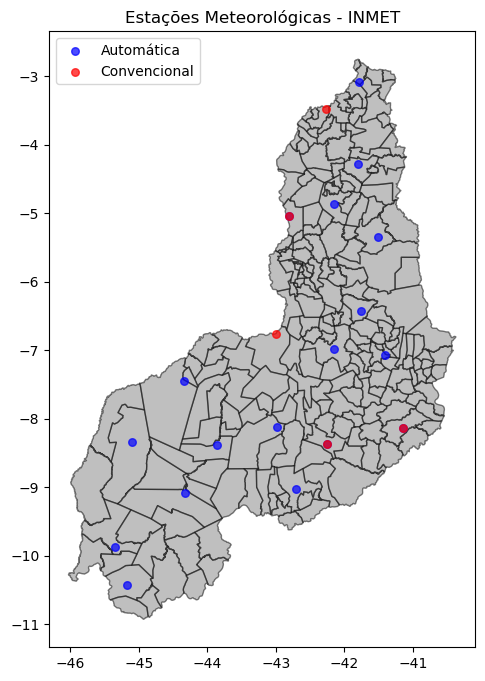

In [11]:
fig = plt.figure(figsize=(12,8))
ax = plt.subplot()
pi.plot(ax=ax, color='gray', alpha=0.5, edgecolor='k')

colors = {'Automática': 'blue', 'Convencional':'red'}
for tipo, color in colors.items():
    subset = station_pi[station_pi['TIPO'] == tipo]
    subset.plot(ax=ax, marker='o', color=color, markersize=30, label=tipo, alpha=0.7)
plt.title('Estações Meteorológicas - INMET')
plt.legend()
plt.show()

### Estações pluviométricas do banco de dados da ANA

In [12]:
station_ana = gpd.read_parquet('dados/EstacoesFluvioPluvio_PiauiOperando.parquet')
#station_ana.head(3)

In [13]:
station_ana_pluv = station_ana[station_ana.TipoEstacao == 'Pluvometrica']
#station_ana_pluv.head(3)

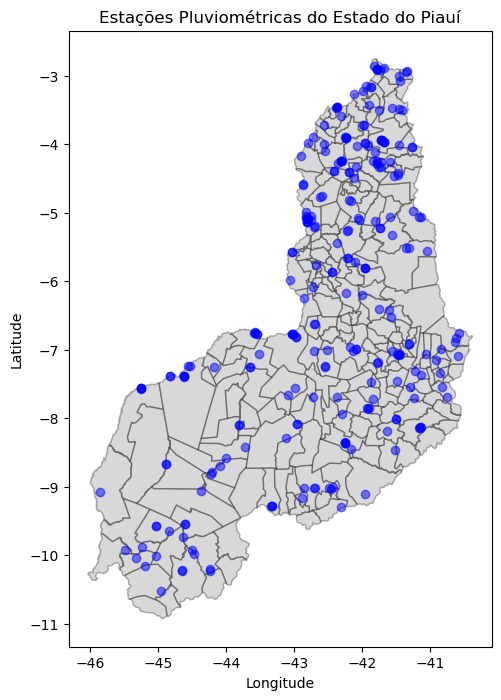

In [14]:
#Visualização
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot()
pi.plot(ax=ax1, color = 'gray', alpha=0.3, edgecolor='k')
#station_pi_auto_loc.plot(ax=ax1, marker='*', color='red')
station_ana.plot(ax=ax1, color='blue', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Estações Pluviométricas do Estado do Piauí')
plt.show()

### Visualização usando o geemap

In [15]:
Map = geemap.Map()

# Convertendo um GeoDataFrame em uma FeatureCollection do GEE
pi_fc = convert_shp_to_fc(pi)
station_ana_pluv_fc = convert_shp_to_fc(station_ana_pluv)
station_pi_2 = convert_shp_to_fc(station_pi)

In [24]:
dem = ee.Image("USGS/SRTMGL1_003").clip(pi_fc)
vis_params = {'min': 0, 'max': 900, 'palette':["5ca36b","9b3b01"]}
Map = geemap.Map(center=(-7.25, -42.15), zoom=6, lite_mode=True)

In [25]:
# Adicionando camadas ao mapa

Map.addLayer(dem, vis_params, 'SRTM')
Map.addLayer(station_ana_pluv_fc,{'color':'red'}, 'Estações Pluvio ANA', 1, 0.5)
Map.addLayer(station_pi_2, {}, 'Estações INMET', 1, 0.7)

Map

Map(center=[-7.25, -42.15], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…